In [1]:
import zipfile
import os
import numpy as np
import shutil
import glob
import pathlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
import cv2

In [7]:
# Unzip the downloaded file
zip_ref = zipfile.ZipFile("/content/dog-and-cat-classification-dataset.zip")
zip_ref.extractall()
zip_ref.close()

In [8]:
ls PetImages/

Cat/  Dog/


## Split the dataset into training and testing also make directories 

In [9]:
# Splitting data into training and test set
df = "/content/PetImages/"

# Defining the path
train = "/content/train"
test = "/content/test"

# Creating directories
os.makedirs(train, exist_ok = True)
os.makedirs(test, exist_ok = True)

# Loop through each class (cat and dog)
for class_name in ["Cat", "Dog"]:
  class_path = os.path.join(df, class_name)

  # getting the list of images files for the current class
  images = os.listdir(class_path)

  # splitting the images into train and test sets
  train_images, test_images = train_test_split(images, test_size = 0.2, random_state = 42)

  # Create the class directories in train and test paths
  train_path = os.path.join(train, class_name)
  test_path = os.path.join(test, class_name)

  os.makedirs(train_path, exist_ok = True)
  os.makedirs(test_path, exist_ok = True)

  # Move images to the appropriate directoreis
  for image in train_images:
    src = os.path.join(class_path, image)
    dst = os.path.join(train_path, image)
    shutil.move(src, dst)

  for image in test_images:
    src = os.path.join(class_path, image)
    dst = os.path.join(test_path, image)
    shutil.move(src, dst)


print("Dataset split into train and test sets")

Dataset split into train and test sets


In [10]:
# let's find out number of images in train (cat)
num_cat_train = len(os.listdir("/content/train/Cat"))
num_cat_train

11618

In [11]:
# let's find out number of images in test(cat)
num_cat_test = len(os.listdir("/content/test/Cat"))
num_cat_test

4146

In [12]:
# checking the class names
data_dir = pathlib.Path("/content/train/")

class_name = np.array(sorted([item.name for item in data_dir.glob("*")]))
class_name

array(['Cat', 'Dog'], dtype='<U3')

## Visualize the images randomly

In [13]:
def view_image_random(target_directory, target_class):
  # Setup the target folder
  target_folder = target_directory + target_class

  # get the random image
  random_image = random.sample(os.listdir(target_folder), 1) # randomly select one item
  print(random_image)

   # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # Show the shape of the image

  return img

['9260.jpg']
Image shape: (375, 500, 3)


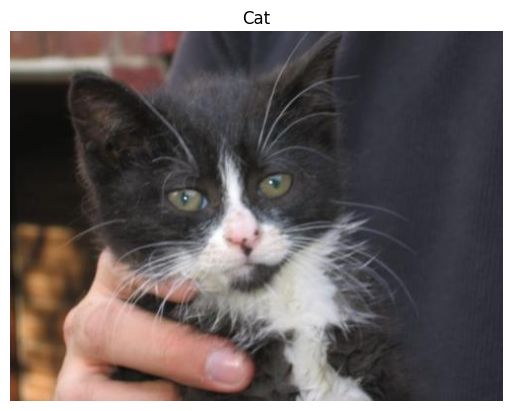

In [14]:
# let's view the random image from the training dataset
img = view_image_random("/content/train/", "Cat")

['10875.jpg']
Image shape: (307, 211, 3)


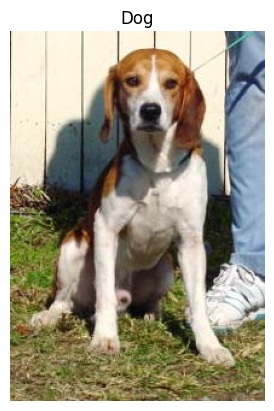

In [15]:
img = view_image_random("/content/train/", "Dog")

['9763.jpg']
Image shape: (381, 285, 3)
['404.jpg']
Image shape: (184, 200, 3)


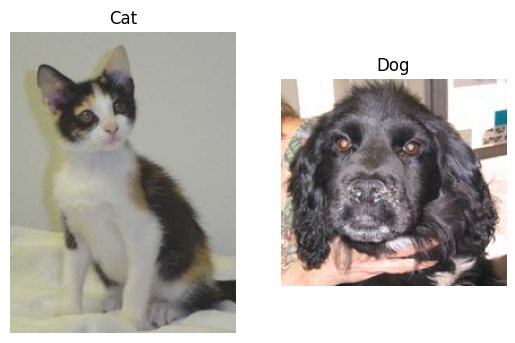

In [16]:
# or we can use this different method
plt.figure()
plt.subplot(1, 2, 1)
cat_img = view_image_random("/content/train/", "Cat")
plt.subplot(1, 2, 2)
dog_img = view_image_random("/content/train/", "Dog")

In [17]:
# type of the image
img.dtype

dtype('uint8')

### Preprocess the data

In [18]:
# define the train and test directory path
train_dir = "/content/train/"
test_dir = "/content/test/"

In [19]:
# Scaling the images
train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

In [20]:
# turn it into batches and use Data augmentation
train_data = train_datagen.flow_from_directory(directory = train_dir,
                                               target_size = (224, 224),
                                               class_mode = "binary",
                                               batch_size = 32)

test_data = test_datagen.flow_from_directory(directory = test_dir,
                                               target_size = (224, 224),
                                               class_mode = "binary",
                                               batch_size = 32)

Found 21617 images belonging to 2 classes.
Found 6646 images belonging to 2 classes.


In [21]:
# get the sample of training batch
imgaes, labels = train_data.next()
len(images), len(labels)

(12499, 32)

## Building the CNN model

1. Load our images
2. Preprocess our images
3. Build a CNN to find patterns in our images
4. Compile our CNN
5. Fit the CNN to our training data


In [35]:
model_1 = Sequential([
    Conv2D(filters = 10,
           kernel_size = 3,
           strides = 1,
           padding = "valid",
           activation = "relu",
           input_shape = (224, 224, 3)),
    Conv2D(10, 3, activation = "relu"),
    MaxPool2D(pool_size = 2),

    Conv2D(10, 3, activation = "relu"),
    Conv2D(10, 3, activation = "relu"),
    MaxPool2D(pool_size = 2),
    Flatten(),
    Dense(1, activation = "sigmoid")
])

In [36]:
# compile the model
model_1.compile(loss = "binary_crossentropy",
              optimizer = Adam(0.001),
                metrics = ["accuracy"])

In [37]:
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 conv2d_11 (Conv2D)          (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 110, 110, 10)      0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 108, 108, 10)      910       
                                                                 
 conv2d_13 (Conv2D)          (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 53, 53, 10)        0         
 g2D)                                                 

In [38]:
# fit the model
history_1 = model_1.fit(train_data,
                        epochs = 5,
                        steps_per_epoch = len(train_data),
                        validation_data = test_data,
                        validation_steps = len(test_data))

Epoch 1/5
321/676 [=============>................] - ETA: 30s - loss: 0.6351 - accuracy: 0.6318

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


676/676 [==============================] - 80s 116ms/step - loss: 0.5996 - accuracy: 0.6708 - val_loss: 0.5115 - val_accuracy: 0.7549
Epoch 2/5
676/676 [==============================] - 74s 110ms/step - loss: 0.4999 - accuracy: 0.7577 - val_loss: 0.4511 - val_accuracy: 0.7982
Epoch 3/5
676/676 [==============================] - 68s 100ms/step - loss: 0.4282 - accuracy: 0.8026 - val_loss: 0.4257 - val_accuracy: 0.8148
Epoch 4/5
676/676 [==============================] - 77s 114ms/step - loss: 0.3616 - accuracy: 0.8418 - val_loss: 0.3899 - val_accuracy: 0.8303
Epoch 5/5
676/676 [==============================] - 75s 111ms/step - loss: 0.3057 - accuracy: 0.8683 - val_loss: 0.3754 - val_accuracy: 0.8492


## View the loss and accuracy curve

In [26]:
def plot_loss_curves(history):

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # plot the loss
  plt.plot(epochs, loss, label = "Training loss")
  plt.plot(epochs, val_loss, label = "Validation loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # plot the accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label = "Training Accuracy")
  plt.plot(epochs, val_accuracy, label = "Validation Accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

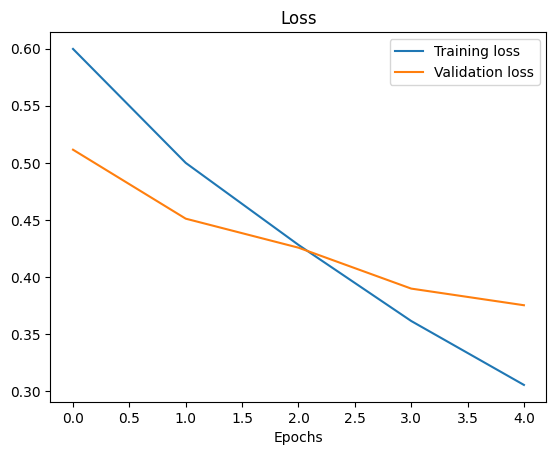

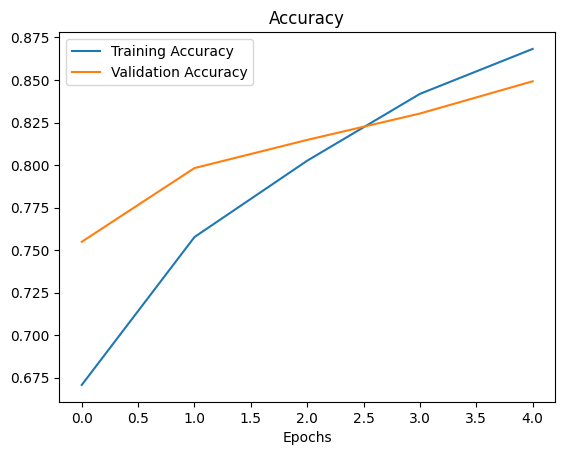

In [40]:
plot_loss_curves(history_1)

In [46]:
# save the model
model_1.save("dog_cat_classification.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Predict the class by using the Computer Vision

In [9]:
# Load the saved model
dog_cat = load_model("dog_cat_classification.h5")

# List of video paths
video_paths = ["Dog.mp4", "Cat.mp4"]

for video_path in video_paths:
    # Open the video to capture objects
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error: Unable to open video {video_path}")
        exit()

    while True:
        ret, frame = cap.read()

        if not ret:
            print("Error: Unable to capture frame")
            break

        # Preprocess the frame for prediction
        img = cv2.resize(frame, (224, 224))
        img = img / 255.0
        img_array = np.expand_dims(img, axis=0)

        # Make predictions
        pred = dog_cat.predict(img_array)
        class_label = "Dog" if pred[0] > 0.5 else "Cat"

        # Draw a rectangle around the detected object
        color = (255, 0, 0) if class_label == "Dog" else (0, 0, 255)

        cv2.putText(frame, class_label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
        cv2.rectangle(frame, (0, 0), (frame.shape[1], frame.shape[0]), color, 2)

        # Display the frame with the rectangle
        cv2.imshow("Detected Object", frame)

        # Press 'q' to exit the loop
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release the video capture object
    cap.release()

# Close all windows
cv2.destroyAllWindows()

1/1 [==============================] - 0s 20ms/step
Error: Unable to capture frame
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


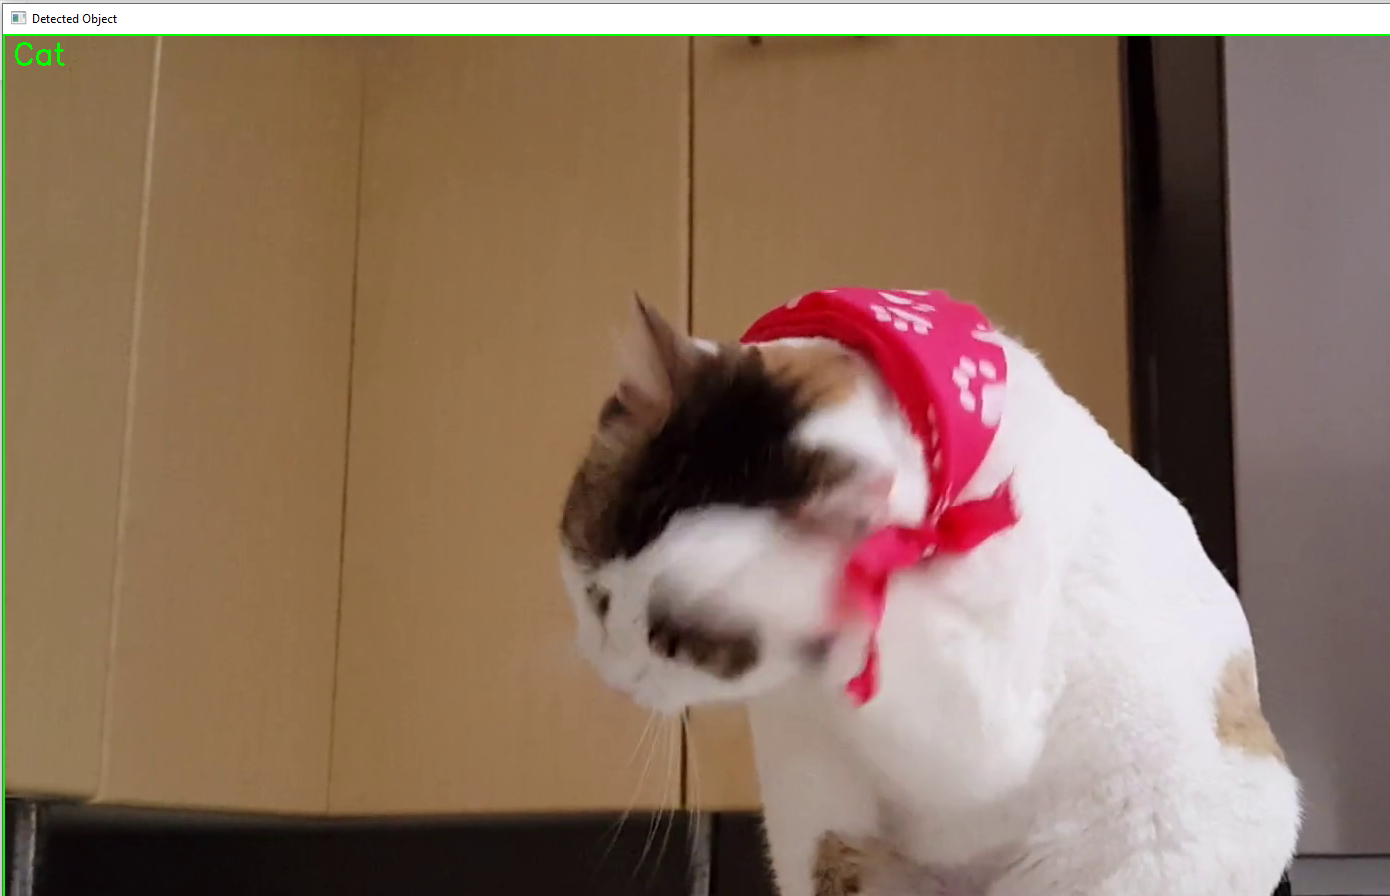

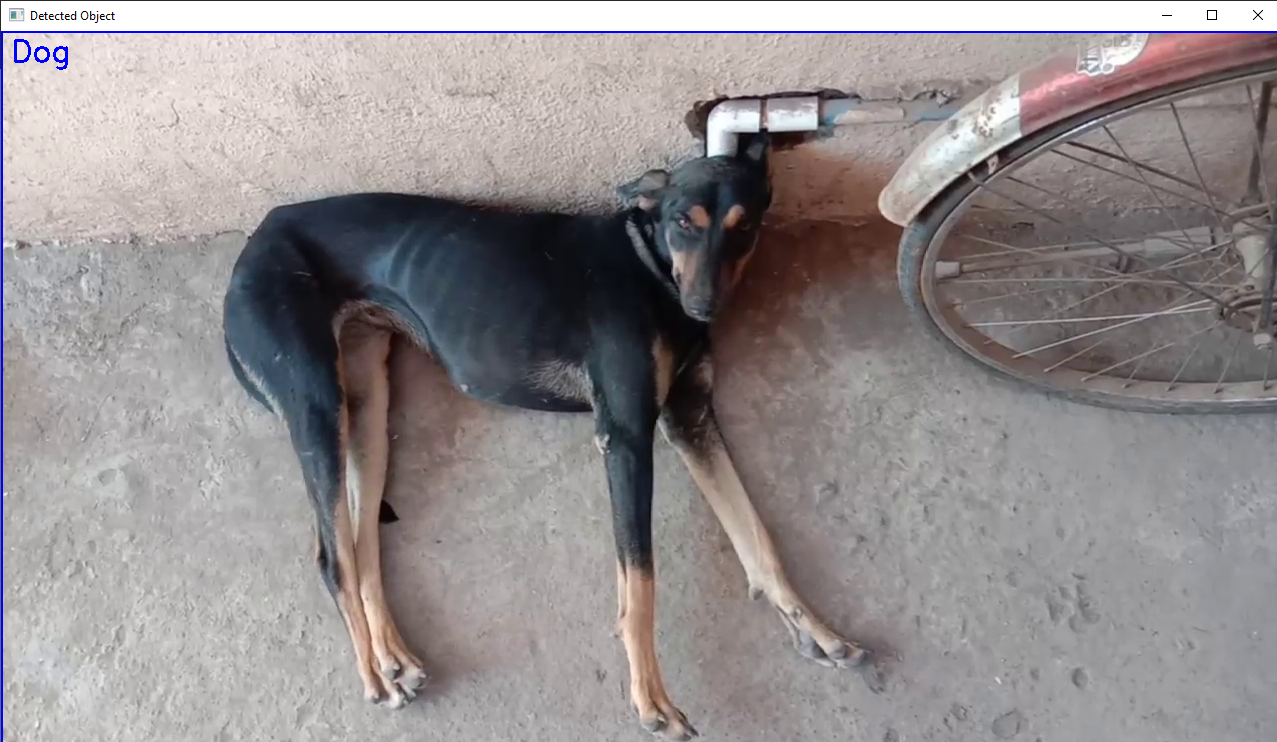